<a href="https://colab.research.google.com/github/MateoMu/TDS_III/blob/master/Proyecto_final_MateoMu%C3%B1ozArroyave_TDS_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

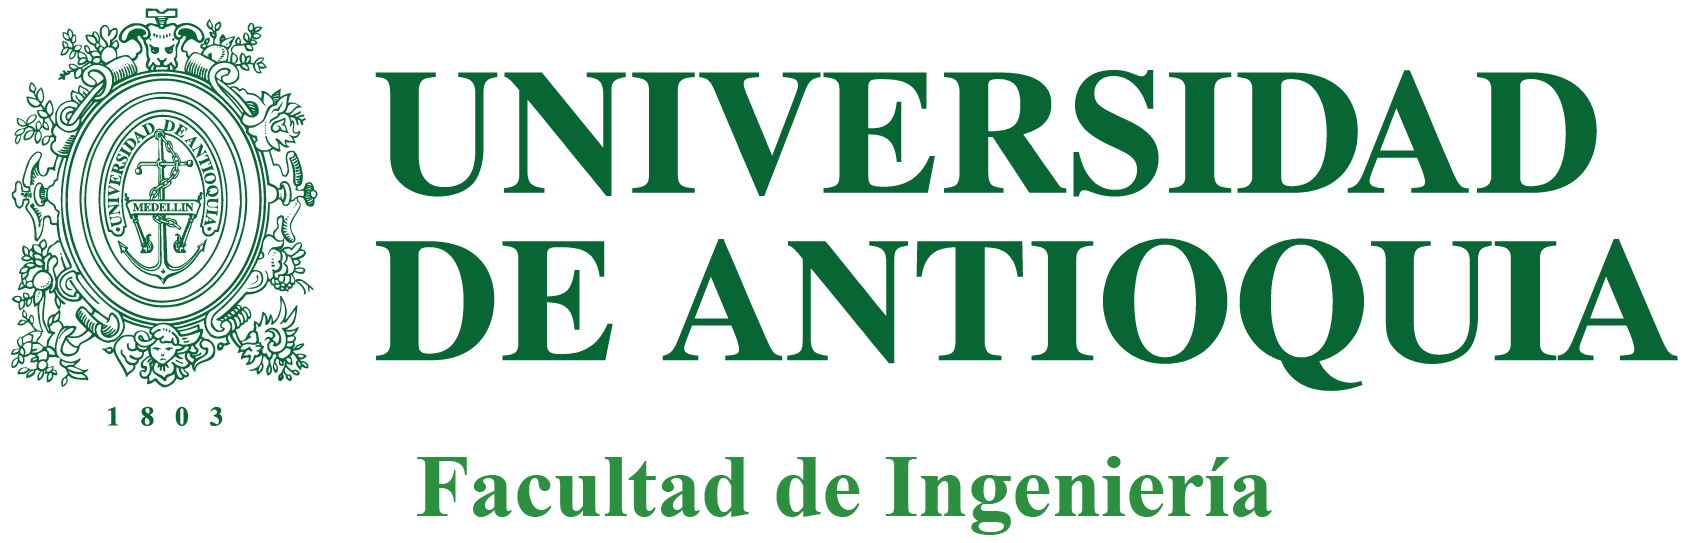
---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Alumno:** Mateo Muñoz Arroyave C.C 1036676919
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

## Final Project Assignment: Modulation Recognition Using Convolutional Neural Networks (CNN) with Database


**Objective:**
- The objective of this final project is to design and implement a modulation recognition system using Convolutional Neural Networks (CNN). The project will involve building a robust CNN model capable of accurately classifying different modulation schemes present in the provided database (RadioML2016). Modulation recognition is a crucial task in wireless communication systems, and your implementation will contribute to the advancement of signal processing in communications.

**Dataset:**
- You will be provided with a dataset (Database RadioML2016) containing samples of signals with various modulation schemes. The dataset is divided into training and testing sets. It is essential to preprocess the data appropriately to feed it into the CNN model.

**Tasks:**

1. Data Preprocessing: Load and explore the dataset to understand its structure and characteristics.
Preprocess the data, including normalization, resizing, and any other necessary steps to prepare it for input into the CNN.
2. CNN Model Architecture:
Design a CNN architecture suitable for modulation recognition. Consider the input shape, number of layers, filter sizes, and activation functions.
Implement the CNN model using a deep learning framework of your choice (e.g., TensorFlow, PyTorch, Keras).
3. Training: Split the dataset into training and validation sets.
Train the CNN model using the training set, monitoring and optimizing for performance on the validation set.
Experiment with different hyperparameters to enhance the model's accuracy.
4. Evaluation: Evaluate the trained model on the testing set to assess its performance in recognizing modulation schemes.
Calculate relevant metrics such as accuracy, precision, recall, and F1 score.
5. Analysis and Visualization: Provide visualizations of the training/validation loss and accuracy over epochs.
Analyze the confusion matrix to understand the model's performance on different modulation schemes.
6. Documentation: Prepare a comprehensive notebook report documenting the entire project, including data exploration, model architecture, training process, evaluation results, and analysis. Include code documentation and comments for clarity.
7. Presentation: Prepare a pitch presentation summarizing key aspects of your project.
Present the motivation, methodology, results, and any challenges faced during the implementation.
8. Submission Guidelines: Submit the project code along with a README file providing instructions on how to run the code (use GIT).
9. Submit the project report in a clear and organized format on GIT repo.
10. Ensure that your implementation is well-documented, and your code follows best practices.


*This final project will not only test your understanding of modulation recognition and CNNs but also your ability to apply machine learning concepts to real-world signal processing challenges.*

Good luck!

In [1]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:09<00:00, 65.7MB/s]


In [30]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import Conv2D
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

In [3]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

In [4]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [5]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

###Recorren todos los datos

In [6]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

###Se añade ruido

In [7]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

###Cada modulacion como un codigo binario

In [8]:
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [9]:
lbl[:10,0]

array(['8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK',
       '8PSK', '8PSK'], dtype='<U21')

In [10]:
lbl[:10,1]

array(['-20', '-20', '-20', '-20', '-20', '-20', '-20', '-20', '-20',
       '-20'], dtype='<U21')

In [11]:
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

###Se devididen los datos de entrenamiento y test

In [12]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [13]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


###Construya el modelo NN
Su tarea aquí es codificar 2 arquitecturas CNN para evaluar el reconocimiento de modulación utilizando enfoques de aprendizaje profundo.

In [25]:
X_train = X_train.reshape(X_train.shape[0], 2, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 2, 128, 1)

# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
#model.add(Convolution2D(...))
model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(2,128,1)))

model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))

model.add(Convolution2D(filters=16, kernel_size=2, padding='same', activation='relu'))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(12, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 2, 128, 64)        320       
                                                                 
 conv2d_20 (Conv2D)          (None, 2, 128, 32)        8224      
                                                                 
 conv2d_21 (Conv2D)          (None, 2, 128, 16)        2064      
                                                                 
 flatten_7 (Flatten)         (None, 4096)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)              

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

###Entrenar el modelo

In [28]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.21093, saving model to ./PESOS_TSIII.wts.h5
165/165 - 7s - loss: 2.3511 - accuracy: 0.1351 - val_loss: 2.2109 - val_accuracy: 0.1879 - 7s/epoch - 41ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 2.21093
165/165 - 4s - loss: 2.2380 - accuracy: 0.1815 - val_loss: 2.2665 - val_accuracy: 0.1936 - 4s/epoch - 23ms/step
Epoch 3/100

Epoch 3: val_loss improved from 2.21093 to 1.88175, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 2.0925 - accuracy: 0.2318 - val_loss: 1.8817 - val_accuracy: 0.2971 - 4s/epoch - 25ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.88175 to 1.66467, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.8226 - accuracy: 0.3226 - val_loss: 1.6647 - val_accuracy: 0.3710 - 4s/epoch - 25ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.66467 to 1.56862, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.6651 - accuracy: 0.3774 - val_loss: 1.5686 - val_accuracy: 0.4120 - 4s/epoch - 24ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.56862 to 1.47378, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.5530 - accuracy: 0.4149 - val_loss: 1.4738 - val_accuracy: 0.4437 - 4s/ep

In [29]:
# Evaluate the model on test set
score = model.evaluate(X_test, Y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5412916541099548


###Evaluacion modelo

In [31]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

71/71 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.40      0.27      0.32      5957
           1       0.50      0.70      0.58      5852
           2       0.26      0.92      0.40      5932
           3       0.82      0.59      0.69      6051
           4       0.82      0.55      0.66      5963
           5       0.74      0.59      0.65      6022
           6       1.00      1.00      1.00      6125
           7       0.89      0.66      0.76      5991
           8       0.39      0.23      0.29      5906
           9       0.55      0.56      0.55      6029
          10       0.47      0.33      0.39      6072
          11       0.61      0.11      0.19      6100

    accuracy                           0.54     72000
   macro avg       0.62      0.54      0.54     72000
weighted avg       0.62      0.54      0.54     72000



### Curva de perdidas

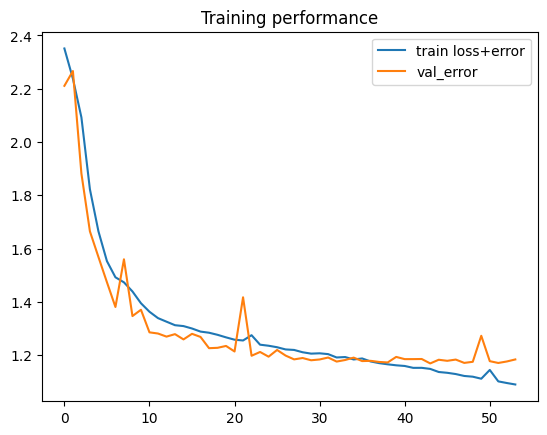

In [32]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

###Matriz de confusión

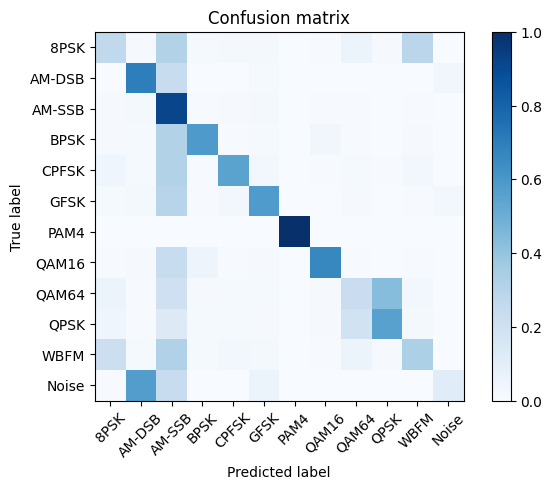

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
classes = mods
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


112/112 [==============================] - 1s 4ms/step
Overall Accuracy for SNR -20: 0.16596814752724226
113/113 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -18: 0.17695929105510938
115/115 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -16: 0.1727247881934955
114/114 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -14: 0.18736203090507728
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -12: 0.21686746987951808
116/116 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -10: 0.2873033098209441
111/111 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -8: 0.39836019225332203
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -6: 0.501819199552197
112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -4: 0.599218531956461
114/114 [==============================] - 0s 3ms/step
Overall A

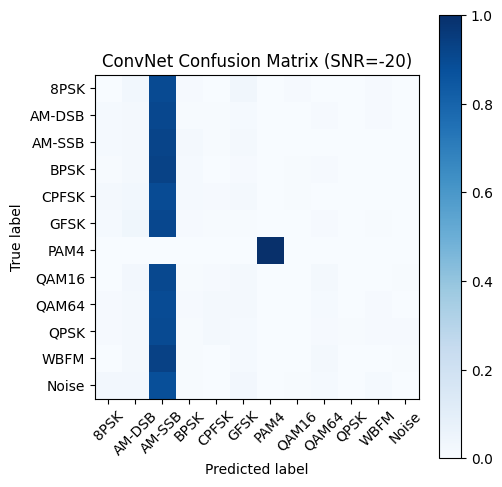

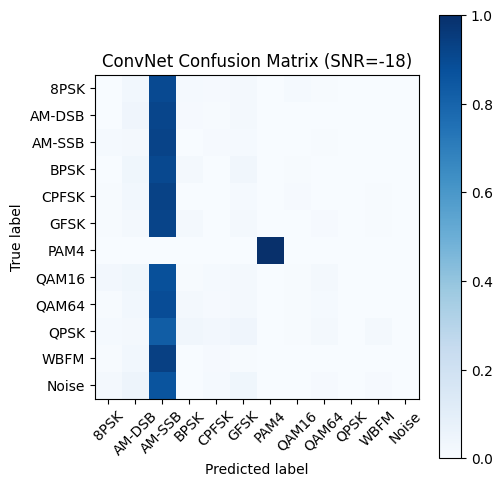

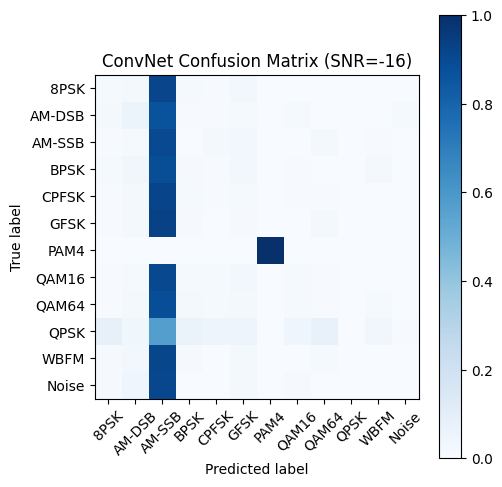

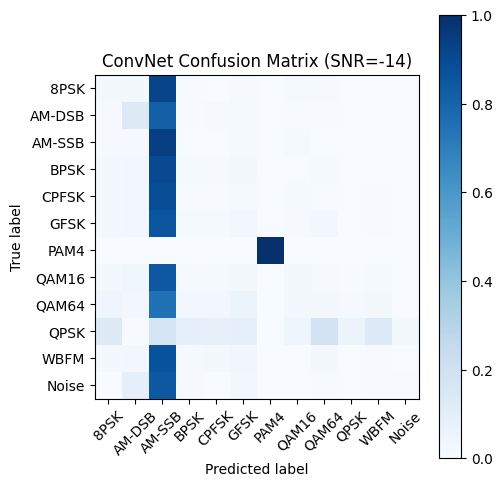

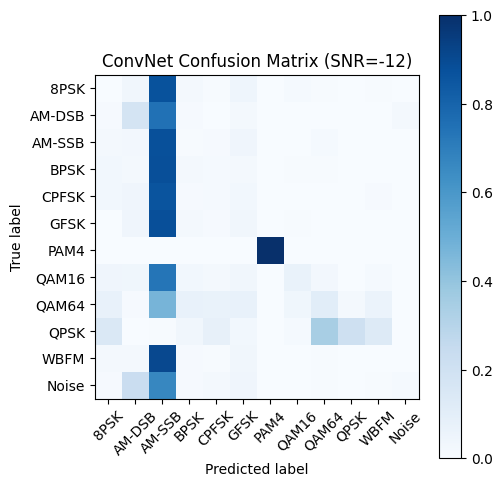

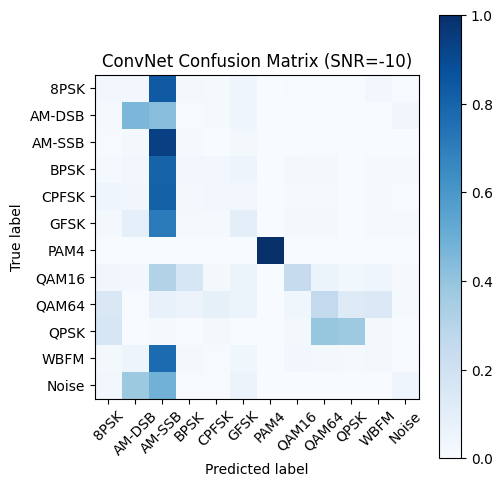

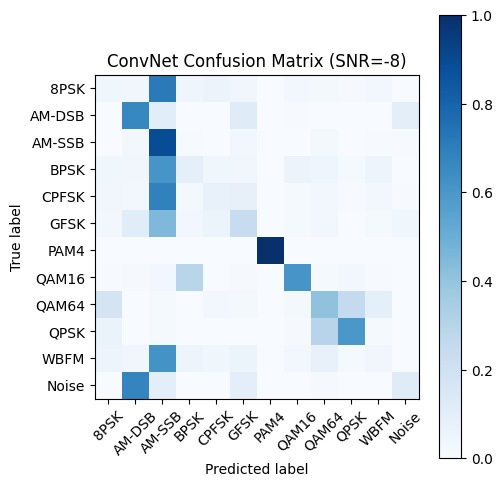

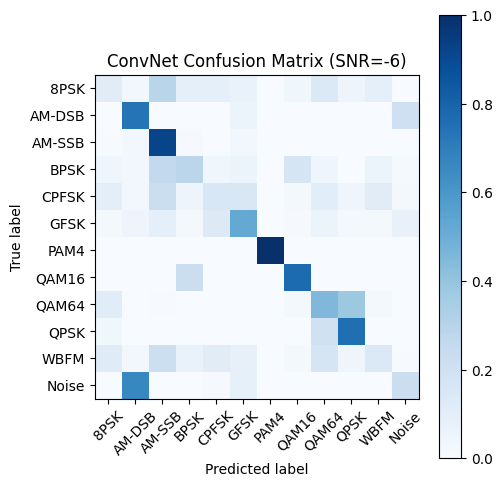

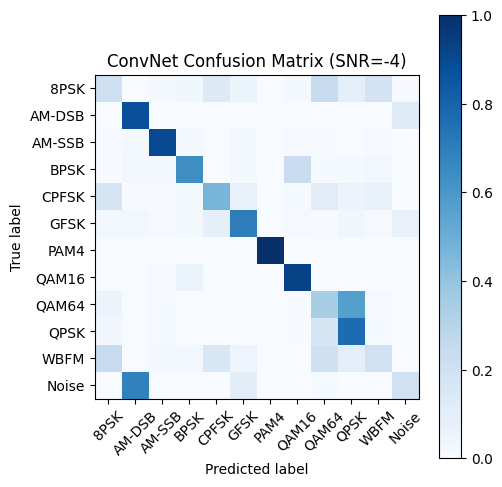

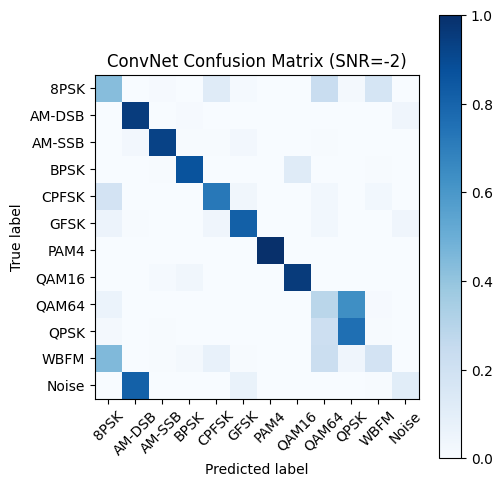

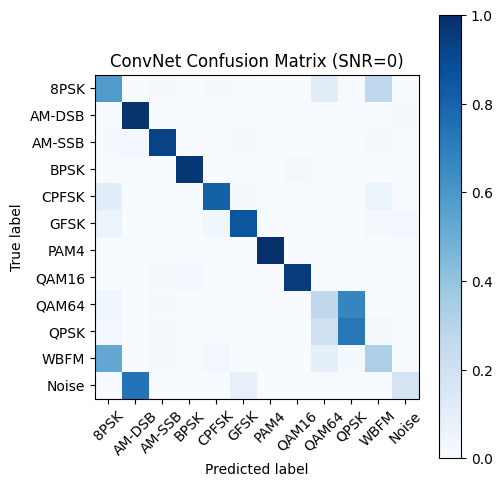

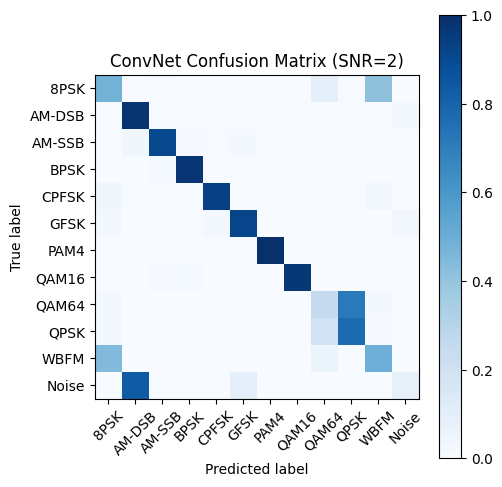

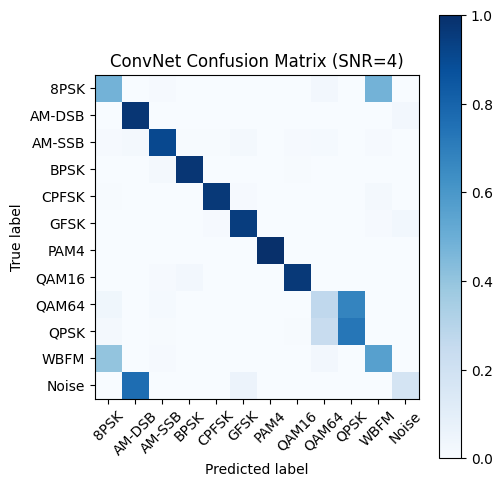

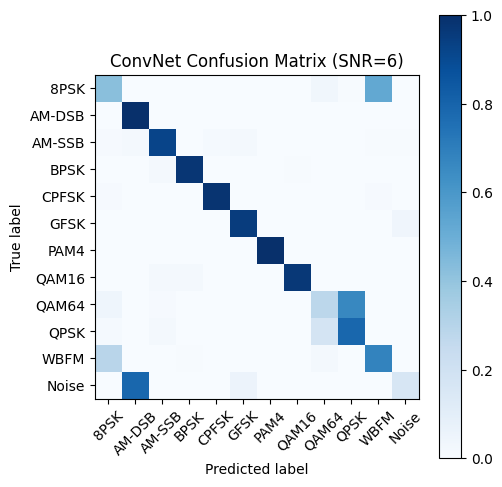

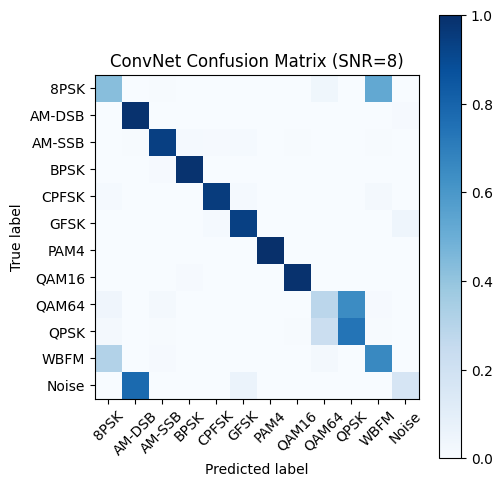

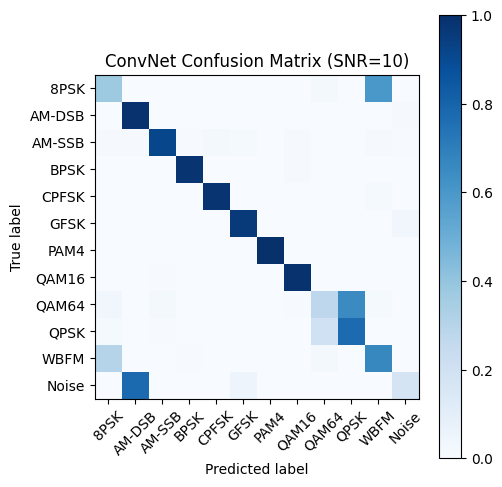

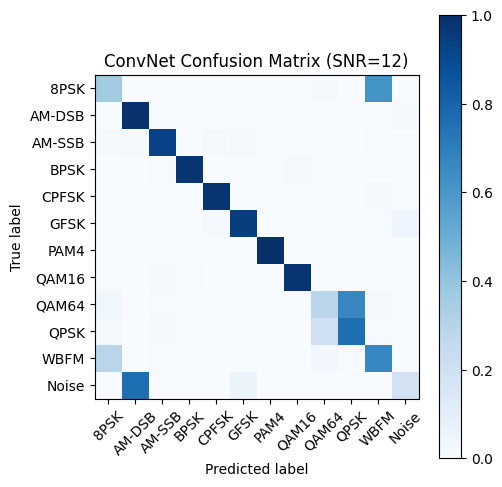

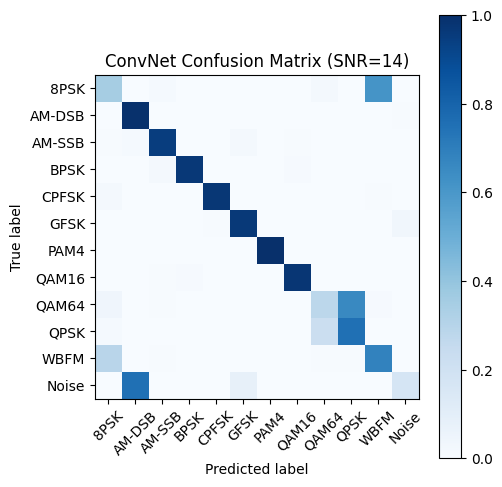

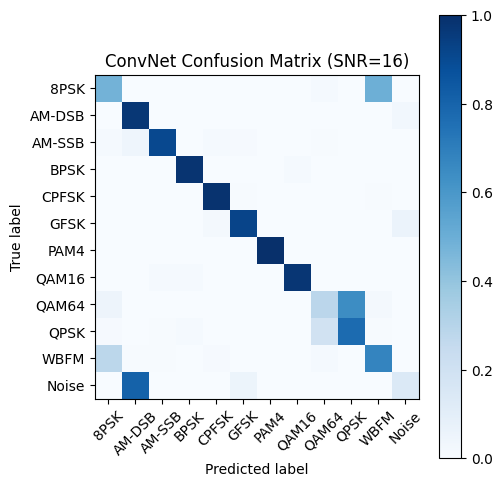

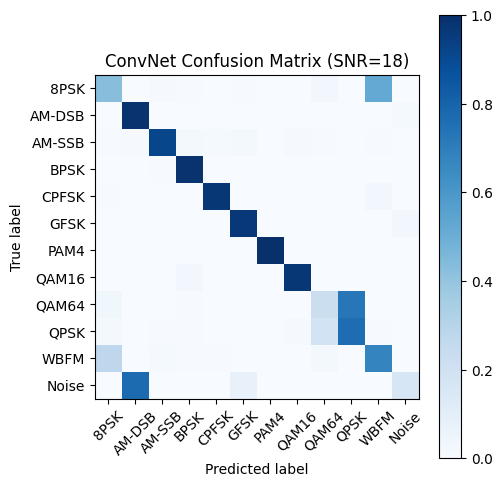

In [39]:
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

###Curva de precision

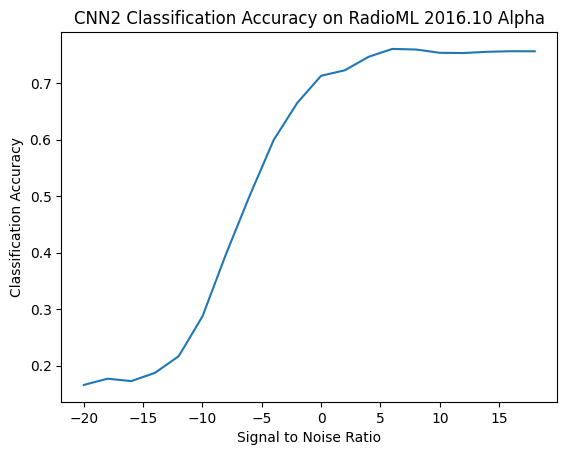

In [42]:
# Plot accuracy curve
a =  map(lambda x: acc[x], snrs)
aux = []
for i in a:
  aux.append(i)
plt.plot(snrs, aux);
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");